# CITS3401 Project 2 Report
## Eddie Atkinson (22487668)

## Introduction
The purpose of the previous exercise was to produce clean, aggregated data and load it into a database where it could be efficiently queried, manipulated and visualised. This component of the project is focused on analysing that data to discover useful and previous unknown trends and patterns using a variety of techniques, including association rule mining, classifcation, numerosity reduction, and machine learning.

## Initial Data Cleaning
Data is stored in the database in normalised tables as part of its snowflake schema. In order to perform analytics on the data it is necessary to denormalise the data, remerging it into a central dataframe. The data used for this analysis is contained in the CSV files that were used to load the data in to database in the first place, however it is easy to imagine a situation where data would be exported in bulk from MSSQL to CSVs using the export wizard.   

To start the data must be loaded into dataframes, remembering that the "~" separator was used on the data for ease of use in the SQL loading scripts:

In [18]:
import pandas as pd

dim_country = pd.read_csv("data/dim_country.csv", sep="~")
dim_education = pd.read_csv("data/dim_education.csv", sep="~")
dim_person = pd.read_csv("data/dim_person.csv", sep="~")
dim_race = pd.read_csv("data/dim_race.csv", sep="~")
dim_relationship = pd.read_csv("data/dim_relationship.csv", sep="~")
dim_work = pd.read_csv("data/dim_work.csv", sep="~")
fact_income = pd.read_csv("data/fact_income.csv", sep="~")

# Have a look at some of the dataframes to check the reading was successful
print(fact_income.head())
print(dim_person.head())

   person_id  capital_gain  capital_loss  hours_pw
0          0          2174             0        40
1          1             0             0        38
2          2             0             0        65
3          3             0             0        37
4          4             0             0        40
   person_id  race_id  country_id  work_id  education_id  relationship_id  \
0          0        0           0        0             0                0   
1          1        0           0        0             0                0   
2          2        0           0        0             0                0   
3          3        0           0        0             0                0   
4          4        0           0        0             0                0   

  gender income_bracket  age  
0      M          <=50K   39  
1      M          <=50K   37  
2      F          <=50K   24  
3      M          <=50K   32  
4      M          <=50K   44  


To demerge the data a central dataframe is incrementally constructed by merging the dataframes on their ID columns and then removing the ID columns from the data set. We'll start by constructing the central dataframe by merging ```dim_person``` with ```fact_income```. 

In [19]:
central_df = fact_income
central_df = central_df.merge(dim_person, on=["person_id"], how="left")
# Drop the person ID, it is no longer needed
central_df.drop(["person_id"], axis=1, inplace=True)
# Have a look at the dataframe to check all went well
print(central_df.head())

   capital_gain  capital_loss  hours_pw  race_id  country_id  work_id  \
0          2174             0        40        0           0        0   
1             0             0        38        0           0        0   
2             0             0        65        0           0        0   
3             0             0        37        0           0        0   
4             0             0        40        0           0        0   

   education_id  relationship_id gender income_bracket  age  
0             0                0      M          <=50K   39  
1             0                0      M          <=50K   37  
2             0                0      F          <=50K   24  
3             0                0      M          <=50K   32  
4             0                0      M          <=50K   44  


Now that central, remerged dataframe has been created, the rest of the dimensions can be merged into it folllowing the same pattern of merging based on IDs followed by ID deletion.

In [20]:
# Process dim_country
central_df = central_df.merge(dim_country, on=["country_id"], how="left")
# Delete country ID
central_df.drop(["country_id"], axis=1, inplace=True)

# Process dim_education
central_df = central_df.merge(dim_education, on=["education_id"], how="left")
# Delete education ID
central_df.drop(["education_id"], axis=1, inplace=True)

# Process dim_race
central_df = central_df.merge(dim_race, on=["race_id"], how="left")
central_df.drop(["race_id"], axis=1, inplace=True)

# Process dim_relationship
central_df = central_df.merge(dim_relationship, on=["relationship_id"], how="left")
central_df.drop(["relationship_id"], axis=1, inplace=True)

# Process dim_work
central_df = central_df.merge(dim_work, on=["work_id"], how="left")
central_df.drop(["work_id"], axis=1, inplace=True)

# Take a final peek at the dataset to check that it's correct
print(central_df.head())

   capital_gain  capital_loss  hours_pw gender income_bracket  age  \
0          2174             0        40      M          <=50K   39   
1             0             0        38      M          <=50K   37   
2             0             0        65      F          <=50K   24   
3             0             0        37      M          <=50K   32   
4             0             0        40      M          <=50K   44   

    country_name  education ethnicity relationship_role marital_relationship  \
0  United-States  Bachelors     White     Not-in-family        Never-married   
1  United-States  Bachelors     White     Not-in-family        Never-married   
2  United-States  Bachelors     White     Not-in-family        Never-married   
3  United-States  Bachelors     White     Not-in-family        Never-married   
4  United-States  Bachelors     White     Not-in-family        Never-married   

  marriage_status work_class    occupation  
0     Not Married  State-gov  Adm-clerical  
1     No

Now that the data has been remerged we can perform analytics. Let's start with association rule mining. 

## Assocation Rule Mining

Association rule mining is concerned with finding frequent itemsets. Association rule mining could be helpful in the context of this dataset for finding out which characteristics are associated with being in a higher income bracket, so that people wishing to increase their income can make data-driven decisions about how to do so. 

Whether an itemset is considered frequent is determined by its support - its relative frequency in the dataset. The minimum support required for an itemset to be considered frequent is highly problem and dataset specific, and so will need to be tuned as part of the analysis to discover meaningful results. 

However, it is not only the frequency of itemsets that is of interest for association rule mining, but also the interaction between itemsets in the data set. The interactions of itemsets are measured with two metrics - confidence and lift. Confidence measures the conditional probability of an itemset containing a particular item or parameter, given that another item or parameter is contained in the itemset. Lift measures the degree to which the presence of a particular item in an itemset increases the occurrence of another, taking into account the popularity of both items in the dataset. Lift is a better measure than confidence as confidence can reveal associations that exist only due to the popularity of one item in the itemset. 

The aim of this analysis is to uncover association rules between particular characteristics and income status, >=50K or <=50K using lift as a metric or if necessary, confidence.

To mine the association rules the ```apyori``` library will be used, if it is not installed on your system, uncomment the command below and run it to install it.

In [21]:
# import sys
# !{sys.executable} -m pip install apyori 

Before we can use the ```apyori``` library to mine association rules the continuous variables in the dataset must be discretised, and the dataframe must be converted to a list of lists, as this is the input format for the ```apyori``` apriori algorithm. 

In [22]:
discrete_df = central_df
# Find the columns that require discretising
print(discrete_df.dtypes)

capital_gain             int64
capital_loss             int64
hours_pw                 int64
gender                  object
income_bracket          object
age                      int64
country_name            object
education               object
ethnicity               object
relationship_role       object
marital_relationship    object
marriage_status         object
work_class              object
occupation              object
dtype: object


The attributes that need to be discretised are:
* Age
* Hours worked per week
* Capital Gain
* Capital Loss

In order to discretise them sensibly let's take a look at their plots.

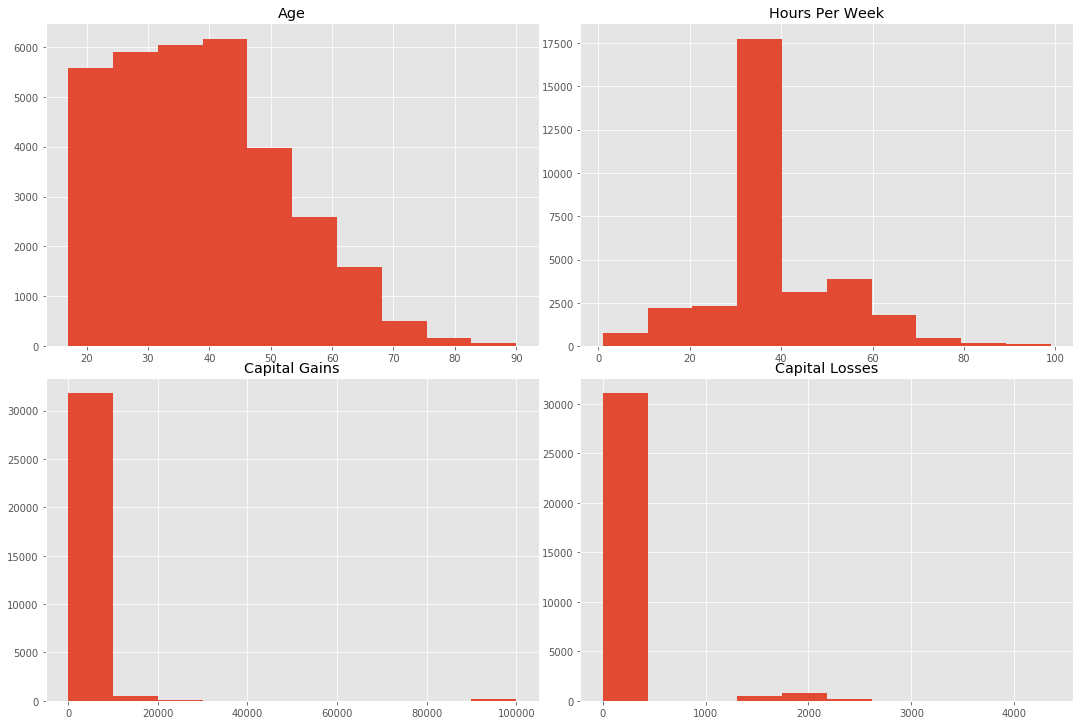

In [23]:
import matplotlib.pyplot as plt
# Matplot lib is pretty ugly, so use ggplot styling
plt.style.use("ggplot")
# Create subplot with two rows and columns with a larger plot size for ease of comparison
fig, axs = plt.subplots(2,2, figsize = (15, 10))
# Spaces the plots out so the titles don't overlap
fig.tight_layout()

# Plot age
axs[0, 0].set_title("Age")
axs[0, 0].hist(discrete_df["age"])

# Plot Hours per week
axs[0, 1].set_title("Hours Per Week")
axs[0, 1].hist(discrete_df["hours_pw"])

# Plot capital gains
axs[1, 0].set_title("Capital Gains")
axs[1, 0].hist(discrete_df["capital_gain"])

# Plot capital losses
axs[1, 1].set_title("Capital Losses")
axs[1, 1].hist(discrete_df["capital_loss"])

plt.show()


Looking at the histograms the following discretisation schemes appear logical and easily interpretable:

- Age: Divide age into bins of size 10 with a maximum of 100.
- Hours worked per week: Divide hours worked per week into bins of size 10, with a maximum of 100.
- Capital gains: Divide capital gains into bins of size 10,000 with a maximum of 100,000.
- Capital losses: Divide capital losses into bins of size 1,000 with a maximum of 5,000.

In [24]:
from discretise import discretise_age
from discretise import discretise_hours
from discretise import discretise_cap_gains
from discretise import discretise_cap_loss


discrete_df["age"] = discrete_df["age"].apply(lambda x: discretise_age(x))
discrete_df["hours_pw"] = discrete_df["hours_pw"].apply(lambda x: discretise_hours(x))
discrete_df["capital_gain"] = discrete_df["capital_gain"].apply(lambda x: discretise_cap_gains(x))
discrete_df["capital_loss"] = discrete_df["capital_loss"].apply(lambda x: discretise_cap_loss(x))

In [ ]:
from apyori import apriori
apriori_list = []
# Iterate through rows converting them to lists and appending them to the apriori list
discrete_df.apply(lambda x: apriori_list.append(x.tolist()), axis=1)

Now that the data is in the correct format we can perform apriori pruning to find the association rules.

In [ ]:
assoc_rules = apriori(apriori_list, min_support=0.0045, min_confidence=0.2, min_lift=1, min_length=2)
assoc_rules = list(assoc_rules)
print(len(assoc_rules))